## Regression Outline
We have a set of manually categorized FERC plants with which to test the sklearn Classifier that we're making. We'll also use them to test the regression analysis here. What does this dataset look like, how was it created?
* Pull FERC Plants table.
* Using a variety of search methods, to ensure that we get a wide variety of plants, identify sets of records in the FERC Form 1 Plants table that are comparable inter-year records.


For regressions, both OLS and sklearn approaches are explored.  Plant generation is normalized by using capacity factor.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np

import scipy
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from pudl import init, analysis, settings, output
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.constants as pc
import pudl.output.pudltabl
import pudl.analysis.analysis
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl()
ferc1_fuel = pudl_out.fuel_ferc1()
ferc1_steam = pudl_out.plants_steam_ferc1()
eia860_plants =  pudl.output.eia860.plants_eia860()
# eia923_plants =  pudl.output.eia923.plants_eia923()

In [5]:
ferc1_fuel.columns

Index(['report_year', 'utility_id_ferc1', 'utility_id_pudl',
       'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name',
       'fuel_consumed_mmbtu', 'fuel_consumed_total_cost_mmbtu',
       'fuel_consumed_total_cost_unit', 'fuel_cost_per_mmbtu',
       'fuel_cost_per_mwh', 'fuel_cost_per_unit_burned',
       'fuel_cost_per_unit_delivered', 'fuel_mmbtu_per_mwh',
       'fuel_mmbtu_per_unit', 'fuel_qty_burned', 'fuel_type_code_pudl',
       'fuel_unit', 'record_id'],
      dtype='object')

In [6]:
# ferc1_fuel = pudl.analysis.analysis.primary_fuel_ferc1(ferc1_fuel)

## Aggregate data from FERC 1 Fuel

In [7]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'})
    )
    return out_df

In [36]:
ferc_cols_to_keep = ['report_year', 'utility_id_ferc1', 'utility_id_pudl',
                     'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name', 'plant_type','installation_year',
                     'opex_per_mwh']

In [37]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    ferc1_fuel.loc[ferc1_fuel.report_year>=2012,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(ferc1_fuel.loc[ferc1_fuel.report_year>=2004,:], ['utility_id_ferc1', 'plant_name'])


In [38]:
coal_fraction_by_plant_name.columns

Index(['report_year', 'utility_id_ferc1', 'plant_name', 'fuel_type_code_pudl',
       'coal_mmbtu', 'total_mmbtu', 'coal_fraction'],
      dtype='object')

In [39]:
ferc1_steam.columns

Index(['report_year', 'utility_id_ferc1', 'utility_id_pudl',
       'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name',
       'asset_retirement_cost', 'avg_num_employees', 'capacity_mw',
       'capex_equipment', 'capex_land', 'capex_per_mw', 'capex_structures',
       'capex_total', 'construction_type', 'construction_year', 'id',
       'installation_year', 'net_generation_mwh',
       'not_water_limited_capacity_mw', 'opex_allowances', 'opex_boiler',
       'opex_coolants', 'opex_electric', 'opex_engineering', 'opex_fuel',
       'opex_misc_power', 'opex_misc_steam', 'opex_operations', 'opex_per_mwh',
       'opex_plants', 'opex_production_total', 'opex_rents', 'opex_steam',
       'opex_steam_other', 'opex_structures', 'opex_transfer',
       'peak_demand_mw', 'plant_capability_mw',
       'plant_hours_connected_while_generating', 'plant_type', 'record_id',
       'water_limited_capacity_mw'],
      dtype='object')

In [40]:
steam_agg_ferc1 = (
    # Only interested in 2004 and later
    ferc1_steam.loc[ferc1_steam.report_year>=2004,:].
    # This ensures we only include plants that use *some* coal
    merge(coal_fraction_by_plant_name, how='inner', on=['report_year', 'utility_id_ferc1', 'plant_name']).
    # Break out the non-fuel OpEx
    assign(opex_nonfuel=lambda x: x['opex_production_total'] - x['opex_fuel']).
    # Aggregate by plant_id_pudl
    groupby(['report_year','plant_id_pudl']).
    agg({'capacity_mw': sum,
         'net_generation_mwh': sum,
         'opex_fuel': sum,
         'opex_nonfuel': sum,
        'opex_allowances': sum,
        'opex_boiler': sum,
        'avg_num_employees': sum,
         'opex_electric': sum,
         'opex_engineering': sum,
         'opex_misc_power': sum,
         'opex_misc_steam': sum,
         'opex_operations': sum,
         'opex_plants': sum,
         'opex_production_total': sum,
         'opex_rents': sum,
         'opex_steam': sum,
         'opex_steam_other': sum,
         'opex_structures': sum,
         'opex_transfer': sum       
        }).
    reset_index().
    # Bring in total heat content per pudl_plant
    merge(fuel_consumed_mmbtu, how='left', on=['report_year', 'plant_id_pudl']).
    # Calculate some other interesting metrics:
    assign(opex_fuel_per_mwh=lambda x: x['opex_fuel'] / x['net_generation_mwh'],
           opex_nonfuel_per_mwh=lambda x: x['opex_nonfuel'] / x['net_generation_mwh'],
           heat_rate_mmbtu_mwh=lambda x: x['fuel_consumed_mmbtu'] / x['net_generation_mwh'],
           capacity_factor=lambda x: x['net_generation_mwh'] / (8760*x['capacity_mw']),
           opex_total_per_mwh=lambda x: x['opex_nonfuel_per_mwh'] + x['opex_fuel_per_mwh']).
    merge(ferc1_steam[ferc_cols_to_keep],how='left',on=['report_year','plant_id_pudl',])
)

In [41]:
coal_plants = coal_fraction_by_plant_name[coal_fraction_by_plant_name.coal_fraction >= 0.85] # returns 96.7% of records

In [42]:
coal_plants[coal_plants.plant_name=='dolet hills']

,report_year,utility_id_ferc1,plant_name,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
27,2004,22,dolet hills,coal,2.634649e+07,2.639074e+07,0.998323
344,2005,22,dolet hills,coal,2.711849e+07,2.711849e+07,1.000000
666,2006,22,dolet hills,coal,2.614793e+07,2.619507e+07,0.998201
990,2007,22,dolet hills,coal,2.110518e+07,2.118594e+07,0.996188
1309,2008,22,dolet hills,coal,2.769405e+07,2.773419e+07,0.998553
1628,2009,22,dolet hills,coal,2.577071e+07,2.584716e+07,0.997042


In [43]:
## This function call replaced by coal fraction calculation
# fuel_df_plant = ferc1_aggregate_by_fuel_type(ferc1_fuel, fuels=['coal'])

In [44]:
new = pd.merge(steam_agg_ferc1, coal_plants, on=['plant_name', 'utility_id_ferc1', 'report_year'], how='right')


In [45]:
new.tail(5)

,report_year,plant_id_pudl,capacity_mw,net_generation_mwh,opex_fuel,opex_nonfuel,opex_allowances,opex_boiler,avg_num_employees,opex_electric,opex_engineering,opex_misc_power,opex_misc_steam,opex_operations,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,fuel_consumed_mmbtu,opex_fuel_per_mwh,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh,capacity_factor,opex_total_per_mwh,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_ferc1,plant_name,plant_type,installation_year,opex_per_mwh,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
4363,2017,654,362.07,2563428.00,35872474.0,15498533.0,0.0,5864192.0,171.0,-127650.0,22831.0,3267423.0,147947.0,409129.0,1268196.0,51371007.0,13012.0,4285422.0,0.0,348031.0,0.0,3.339897e+07,13.993946,6.046018,13.029024,0.808210,20.039965,134,246,PacifiCorp,404,wyodak,steam,1978.0,20.7,coal,2.495435e+07,2.496917e+07,0.999406
4364,2017,654,362.07,2563428.00,35872474.0,15498533.0,0.0,5864192.0,171.0,-127650.0,22831.0,3267423.0,147947.0,409129.0,1268196.0,51371007.0,13012.0,4285422.0,0.0,348031.0,0.0,3.339897e+07,13.993946,6.046018,13.029024,0.808210,20.039965,12,42,"Black Hills Power, Inc.",51,wyodak bhp 20% share,steam,1978.0,17.7,coal,8.429790e+06,8.429790e+06,1.000000
4365,2017,659,1019.00,2639668.22,78615636.0,29672269.0,0.0,5750050.0,242.0,358773.0,2872709.0,7208907.0,1463378.0,758346.0,828760.0,108287905.0,0.0,7425508.0,0.0,3005838.0,0.0,2.709685e+07,29.782393,11.240909,10.265247,0.295713,41.023301,57,123,Georgia Power Company,216,wansley,steam,1978.0,41.0,coal,2.709685e+07,2.709685e+07,1.000000
4366,2017,7866,1873.00,9341524.00,222479387.0,116350482.0,117755.0,48700772.0,319.0,2330087.0,3000817.0,31499582.0,9228396.0,2115263.0,14856206.0,338829869.0,0.0,1632551.0,0.0,2869053.0,0.0,1.008212e+08,23.816177,12.455193,10.792798,0.569345,36.271370,74,146,Indianapolis Power & Light Company,246,petersurg,steam,1986.0,36.3,coal,1.006111e+08,1.008212e+08,0.997916
4367,2017,10287,89.00,544431.84,7409426.0,8449164.0,0.0,2697270.0,200.0,524728.0,32590.0,179841.0,1145576.0,506765.0,421399.0,15858590.0,11741.0,2859507.0,0.0,69747.0,0.0,5.089466e+06,13.609465,15.519232,9.348215,0.698312,29.128697,294,352,"Wabash Valley Power Association, Inc.",1212,prairie state,steam,2012.0,29.1,coal,5.072929e+06,5.089466e+06,0.996751


In [46]:
new.groupby(['report_year','plant_id_pudl', 'capacity_mw', 'net_generation_mwh', 'opex_fuel',
            'opex_nonfuel','avg_num_employees','opex_production_total','fuel_consumed_mmbtu', 'opex_fuel_per_mwh',
            'opex_nonfuel_per_mwh','heat_rate_mmbtu_mwh','capacity_factor','opex_total_per_mwh', 'installation_year'], as_index=False).agg({'coal_mmbtu': sum,
         'total_mmbtu':sum}, as_index=False)

,report_year,plant_id_pudl,capacity_mw,net_generation_mwh,opex_fuel,opex_nonfuel,avg_num_employees,opex_production_total,fuel_consumed_mmbtu,opex_fuel_per_mwh,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh,capacity_factor,opex_total_per_mwh,installation_year,coal_mmbtu,total_mmbtu
0,2012,1,1010.74,4.179164e+06,1.509734e+08,32534395.0,115.0,1.835078e+08,4.720934e+07,36.125250,7.784904,11.296359,0.472004,43.910154,1986.0,4.711308e+07,4.720934e+07
1,2012,2,279.00,1.888924e+06,3.300376e+07,7534465.0,67.0,4.053823e+07,1.945038e+07,17.472256,3.988760,10.297067,0.772870,21.461016,1978.0,1.943926e+07,1.945038e+07
2,2012,3,619.38,3.718244e+06,1.149741e+08,24992405.0,102.0,1.399665e+08,4.000616e+07,30.921618,6.721561,10.759422,0.685293,37.643179,1985.0,3.993675e+07,4.000616e+07
3,2012,6,598.40,3.364279e+06,7.743342e+07,30354466.0,85.0,1.077879e+08,3.344345e+07,23.016351,9.022577,9.940747,0.641795,32.038928,1968.0,3.338318e+07,3.344345e+07
4,2012,8,530.46,2.335179e+06,6.483777e+07,38418730.0,107.0,1.032565e+08,2.679373e+07,27.765652,16.452156,11.473953,0.502532,44.217808,1986.0,2.592808e+07,2.628347e+07
5,2012,14,1155.00,1.948724e+06,9.415698e+07,32613773.0,140.0,1.267708e+08,2.121262e+07,48.317250,16.735963,10.885391,0.192604,65.053213,1961.0,2.104712e+07,2.121262e+07
6,2012,16,8798.90,3.890714e+07,1.163760e+09,305341680.0,999.0,1.469102e+09,3.867291e+08,29.911228,7.847960,9.939799,0.504774,37.759189,1973.0,3.851542e+08,3.867291e+08
7,2012,20,158.50,7.921660e+05,2.058267e+07,12144032.0,46.0,3.272670e+07,9.822068e+06,25.982770,15.330161,12.399003,0.570536,41.312931,1955.0,9.266360e+06,9.822068e+06
8,2012,23,231.55,1.167969e+06,3.489353e+07,8117149.0,58.0,4.301068e+07,1.299837e+07,29.875391,6.949798,11.129033,0.575814,36.825189,1986.0,1.298822e+07,1.299837e+07
9,2012,25,754.40,2.022605e+06,1.136226e+08,21999007.0,89.0,1.356216e+08,4.634640e+07,56.176378,10.876571,22.914210,0.306059,67.052950,1971.0,4.136603e+07,4.634640e+07


In [47]:
new.installation_year = pd.to_numeric(new.installation_year, errors='coerce')

In [48]:
# What types of fuel are included in the training data set?
new.plant_type.unique()

array(['steam', 'combustion_turbine', None, 'internal_combustion',
       'nuclear', 'combined_cycle'], dtype=object)

In [50]:
new[new.plant_type=='nuclear']

,report_year,plant_id_pudl,capacity_mw,net_generation_mwh,opex_fuel,opex_nonfuel,opex_allowances,opex_boiler,avg_num_employees,opex_electric,opex_engineering,opex_misc_power,opex_misc_steam,opex_operations,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,fuel_consumed_mmbtu,opex_fuel_per_mwh,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh,capacity_factor,opex_total_per_mwh,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_ferc1,plant_name,plant_type,installation_year,opex_per_mwh,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
1167,2007,236,991.64,6915236.0,59256251.0,100983818.0,1568348.0,15345478.0,432.0,2637837.0,16204272.0,35817259.0,3755137.0,1864418.0,1639943.0,160240069.0,0.0,7482168.0,0.0,9768378.0,0.0,NaN,8.568941,14.603091,NaN,0.796066,23.172032,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,21.0,coal,3.561636e+07,3.569841e+07,0.997702
1515,2008,236,991.58,6445976.0,56999047.0,118198990.0,1619121.0,19409124.0,456.0,2882772.0,20025268.0,41614235.0,5051814.0,1933758.0,6069879.0,175198037.0,0.0,9905998.0,0.0,4255394.0,0.0,NaN,8.842578,18.336865,NaN,0.742090,27.179443,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,24.1,coal,3.108909e+07,3.115105e+07,0.998011
1858,2009,236,972.85,7405733.0,72803775.0,83117386.0,1161292.0,8428191.0,454.0,2932955.0,11620825.0,39337257.0,3041756.0,2410468.0,1472575.0,155921161.0,0.0,6385438.0,0.0,1735373.0,0.0,NaN,9.830732,11.223384,NaN,0.868997,21.054116,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,17.5,coal,2.915212e+07,2.917190e+07,0.999322
2198,2010,236,972.85,4602948.0,64693238.0,143555962.0,665839.0,39632395.0,394.0,3034134.0,22657600.0,45278687.0,4675188.0,2622245.0,4219829.0,208249200.0,0.0,11122373.0,0.0,3993375.0,0.0,NaN,14.054740,31.187830,NaN,0.540115,45.242571,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,44.7,coal,3.056065e+07,3.059554e+07,0.998859
2529,2011,236,972.85,6932566.0,64339588.0,121714880.0,292584.0,18868442.0,407.0,3301312.0,10217228.0,72290502.0,5132130.0,3077218.0,2326594.0,186054468.0,0.0,224560.0,0.0,1933019.0,0.0,NaN,9.280775,17.556974,NaN,0.813475,26.837749,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,24.1,coal,1.715570e+07,1.722858e+07,0.995770
2860,2012,236,1033.80,5602883.0,54438733.0,206567942.0,89350.0,45394450.0,492.0,3088086.0,17413703.0,91667444.0,4703236.0,3165471.0,20746302.0,261006675.0,0.0,11574131.0,0.0,4183063.0,0.0,7.103493e+06,9.716200,36.868152,1.267828,0.618687,46.584352,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,44.6,coal,7.013392e+06,7.103493e+06,0.987316


In [51]:
# Unique plants
# steam_plants = new.sort_values('installation_year').drop_duplicates(subset=['capacity_mw', 'plant_name'], keep='last') # 1007 'plants'
# ct = out_df_ct.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 584 'plants'
# cc = out_df_cc.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 188 'plants'
# ic = out_df_ic.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 147 'plants'
# nuc = out_df_n.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 5 'plants'
# pv = out_df_pv.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 3 'plants'


In [61]:
# # Remove null values for variables of interest, for purposes of histogram plotting
# steam_plants = steam_plants[steam_plants.construction_year.notnull()]
new = new[new.installation_year.notnull()]
new = new.loc[(new['installation_year'] > 1900)]

# steam_plants = steam_plants[steam_plants.capacity_mw.notnull()]
# steam_plants = steam_plants[steam_plants.heat_rate.notnull()]

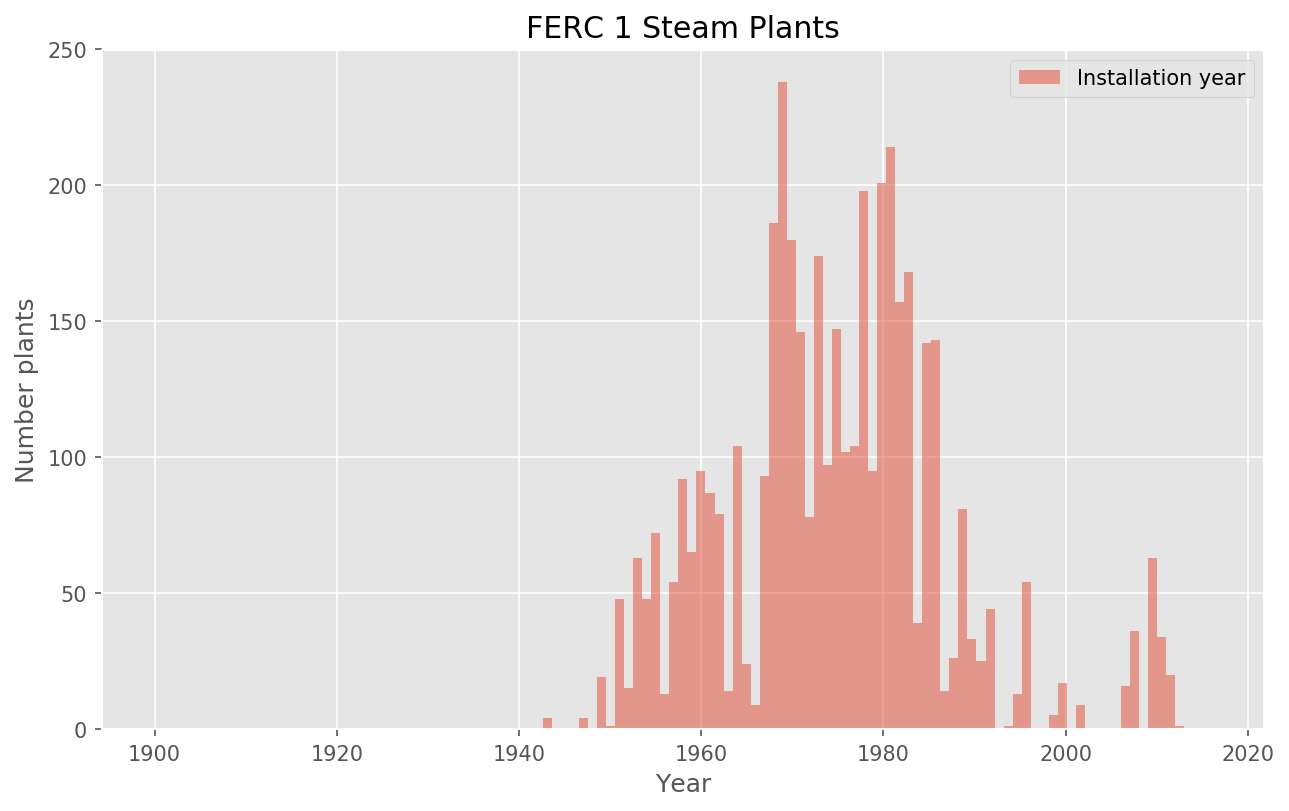

In [62]:
# Look at distribution of construction years vs. installation years.
fig = plt.figure()

plt.xlabel('Year')
plt.ylabel('Number plants')
plt.title('FERC 1 Steam Plants')

# mpl.pyplot.hist(new.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(new.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

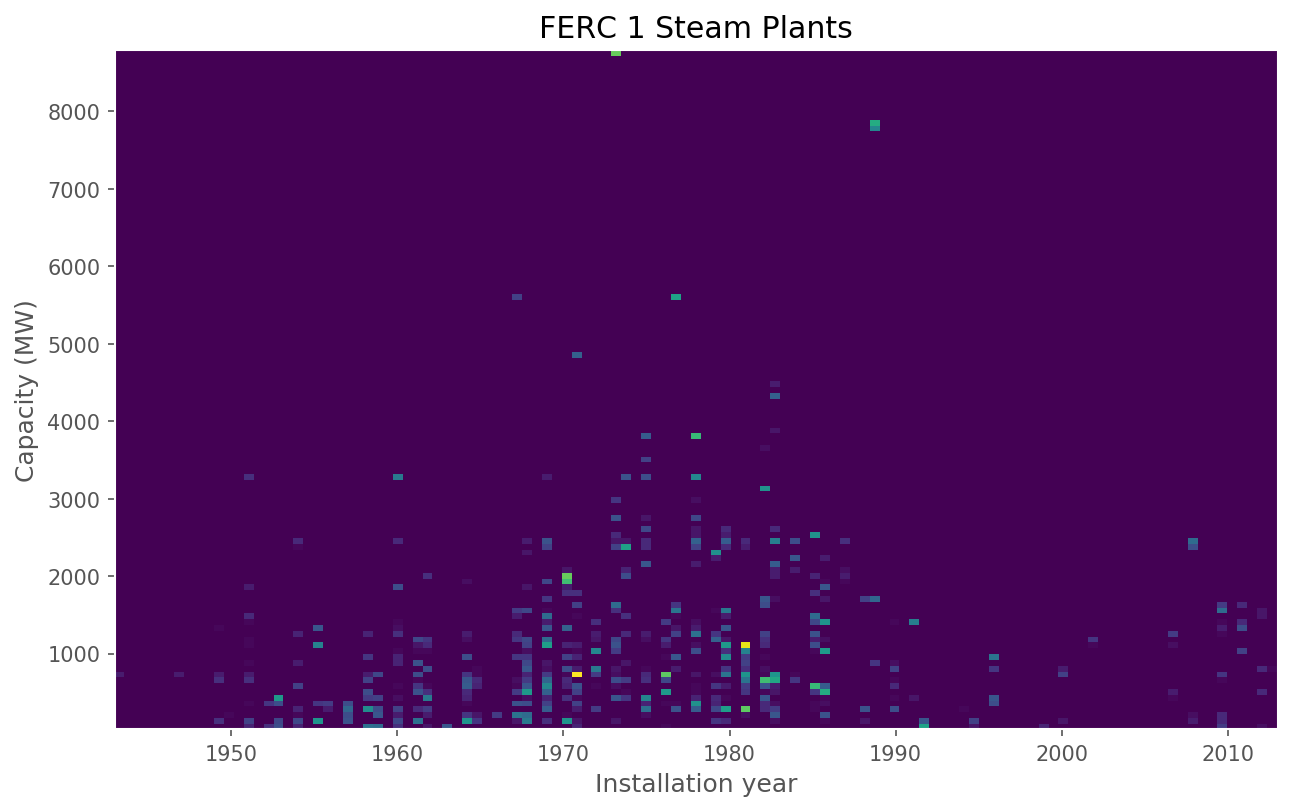

In [63]:
plt.xlabel('Installation year')
plt.ylabel('Capacity (MW)')
plt.title('FERC 1 Steam Plants')
# plt.legend()

mpl.pyplot.hist2d(new.installation_year, new.capacity_mw, bins=117);

# fig.colorbar(im);
#1940 and forward, up to 3K megawatts, just steam - natural groupings?
# install, constru, capacity, and HR then we should find groupings to work wtih.

In [66]:
new.plant_id_pudl.nunique()

249

### Manual binning of construction year, installation year

In [67]:
# oldest = new.loc[(new['construction_year'] < 1956)]
# older = new.loc[(new['construction_year'] >= 1946) & (new['construction_year']< 1956)]
# mid = new.loc[(new['construction_year'] >= 1956) & (new['construction_year']< 1966)]
# newer = new.loc[(new['construction_year'] >= 1966) & (new['construction_year']< 1986)]
# newest = new.loc[new['construction_year'] >= 1986]

In [68]:
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=oldest).fit()
# # print(res.params)
# print("Adj. R-squared = ")
# print(res.rsquared_adj)
# print("")
# print(res.params)

In [69]:
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=older).fit()
# # print(res.params)
# print("R-squared = ")
# print(res.rsquared_adj)
# print("")
# print(res.params)

In [70]:
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=mid).fit()
# # print(res.params)
# print("R-squared = ")
# print(res.rsquared_adj)
# print("")
# print(res.params)

In [71]:
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newer).fit()
# # print(res.params)
# print("R-squared = ")
# print(res.rsquared_adj)
# print("")
# print(res.params)

In [72]:
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw', data=newest).fit()
# # print(res.params)
# print("R-squared = ")
# print(res.rsquared_adj)
# print("")
# print(res.params)

In [73]:
oldest = new.loc[(new['installation_year'] < 1956)]
older = new.loc[(new['installation_year'] >= 1946) & (new['installation_year']< 1956)]
mid = new.loc[(new['installation_year'] >= 1956) & (new['installation_year']< 1966)]
newer = new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986)]
newest = new.loc[new['installation_year'] >= 1986]

In [75]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=oldest).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7480490497957579

Intercept             864007.080609
net_generation_mwh        -0.000185
capacity_mw            36637.742222
dtype: float64


In [76]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=older).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7480497026177764

Intercept             857590.861766
net_generation_mwh        -0.000884
capacity_mw            36639.846438
dtype: float64


In [77]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=mid).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.6604391132082154

Intercept             1.005248e+06
net_generation_mwh    5.924007e-01
capacity_mw           3.565150e+04
dtype: float64


In [78]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=newer).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7582283750258236

Intercept             4.258925e+06
net_generation_mwh   -1.675226e+00
capacity_mw           4.020751e+04
dtype: float64


In [80]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=newest).fit()
# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.8527561668951208

Intercept            -2.467944e+07
net_generation_mwh   -3.099630e+00
capacity_mw           9.731172e+04
dtype: float64


In [81]:
# new['construct_bin'] = 0
# new.loc[(new['construction_year'] < 1956), 'construct_bin'] = 1
# # new.loc[(new['construction_year'] >= 1946) & (new['construction_year']< 1956), 'construct_bin'] = 2
# new.loc[(new['construction_year'] >= 1956) & (new['construction_year']< 1966), 'construct_bin'] = 3
# new.loc[(new['construction_year'] >= 1966) & (new['construction_year']< 1986), 'construct_bin'] = 4
# new.loc[new['construction_year'] >= 1986, 'construct_bin'] = 5
# new.construct_bin = new.construct_bin.astype('category')

In [82]:
new['install_bin'] = 0
new.loc[(new['installation_year'] < 1955), 'install_bin'] = 1
# new.loc[(new['installation_year'] >= ) & (new['installation_year']< 1956), 'install_bin'] = 2
new.loc[(new['installation_year'] >= 1955) & (new['installation_year']< 1966), 'install_bin'] = 3
new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986), 'install_bin'] = 4
new.loc[new['installation_year'] >= 1986, 'install_bin'] = 5
new.install_bin = new.install_bin.astype('category')

## Regressions using binned/unbinned fields

In [85]:
# # Some variables treated as categorical
# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# # print(res.params)
# print(res.summary())


In [86]:
# # Some variables treated as categorical
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# # print(res.params)
# print(res.summary())

In [87]:
# # Some variables treated as categorical
# res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + C(construct_bin) +  C(install_bin)', data=new).fit()
# # print(res.params)
# print(res.summary())

In [88]:
# # All variables treated as continuous
# res = sm.OLS.from_formula('non_fuel_costs ~ capacity_mw + net_generation_mwh + construction_year + installation_year', new).fit()
# print(res.summary())

# Further/future regression exlorations

In [ ]:
# Set up variables for OLS regression 

# X = new[["net_generation_mwh", "heat_rate"]]
X = new[["capacity_mw", "net_generation_mwh"]]
# X = new[["non_fuel_costs"]]
# X = new[["expns_fuel"]]

# y = new["opex_fuel"]
y = new[["non_fuel_costs"]]
# y = new[["net_generation_mwh"]]


X = sm.add_constant(X) ## add an intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

In [ ]:
# Use sklearn linear_model to fit the same regression
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
# print(predictions)[0:5]
lm.score(X,y)

In [ ]:
scipy.stats.linregress(out_df.net_generation_mwh, out_df.non_fuel_costs)

In [ ]:
# numpy.polyfit(ferc1_training_steam.net_generation, ferc1_training_steam.expns_fuel, 1)

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

In [ ]:
x = out_df.net_generation_mwh
y = out_df.non_fuel_costs
x_reshape = out_df_s.net_generation_mwh.values.reshape(-1,1)
y_reshape = out_df_s.non_fuel_costs.values.reshape(-1,1)

In [ ]:
# intercept, slope, corr_coeff = plot_linear_regression(x_reshape, y_reshape)
# plt.show()


In [ ]:
plt.plot(x,y,'.')
plt.title('FERC 1 steam records')
plt.xlabel('net generation (mwh)')
plt.ylabel('non-fuel costs')

In [ ]:
### Exploration of other approaches...

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [ ]:
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [ ]:
ridge = Ridge(fit_intercept=True, alpha=0.5)

In [ ]:
ridge.fit(x_reshape,y_reshape)

In [ ]:
sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# ferc1_training_steam.net_generation_mwh, ferc1_training_steam.non_fuel_costs)

In [ ]:
clf = sklearn.linear_model.Ridge(alpha=1)
clf = sklearn.linear_model.Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)

clf.fit(x_reshape, y_reshape)
# Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
result = clf.fit(x_reshape, y_reshape, sample_weight=None)

In [ ]:
clf.score(x_reshape,y_reshape)

In [ ]:
result.get_params()